In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=7efe368f96458eb70138d44148398d2ad4cc9380abceaf25657de7733d4ce919
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import json

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def trunc(text):
    return text[:-4]

In [ ]:
ase_rows = pd.read_feather("/content/drive/MyDrive/ase_data/ase_rows_only_with_p_localized.feather")

In [ ]:
output_list = pd.read_csv('/content/drive/MyDrive/ase_data/TCGA_localized_PCa_subtypes.txt', sep= "\t")

In [ ]:
output_list = output_list.rename(columns={"Unnamed: 0": "caseID"})

In [ ]:
file = open("/content/drive/MyDrive/ase_data/ASE_localized_recurr10perc.txt", "r")
content = file.read()
file.close()

ase_localized_recurr10perc = content.split("\n")
ase_localized_recurr10perc.pop()

''

In [ ]:
# Convert boolean columns to integers (True to 1, False to 0)
binary_columns = ['SPOP', 'FOXA1', 'MSI', 'TMPRSS2--ERG fusion', 'PTEN deletion']
output_list[binary_columns] = output_list[binary_columns].astype(int)

# Extract binary vectors per row (caseID)
binary_vectors = output_list[binary_columns].values.tolist()

# Optionally, create a dictionary with caseID as keys and binary vectors as values
caseID_vectors = dict(zip(output_list['caseID'], binary_vectors))

In [ ]:
ase_rows['caseID'] = ase_rows['caseID'].apply(trunc)

In [ ]:
ase_rows_filtered = ase_rows[['caseID', 'genename', 'ase', 'foldc_adjust_new']]
ase_rows_filtered

,caseID,genename,ase,foldc_adjust_new
0,TCGA-ZG-A9NI,ZYX,0,1.129678
1,TCGA-ZG-A9NI,ZWINT,0,2.144539
2,TCGA-ZG-A9NI,ZRANB2,0,1.230258
3,TCGA-ZG-A9NI,ZNFX1,0,1.110871
4,TCGA-ZG-A9NI,ZNF84,0,1.879898
...,...,...,...,...
1493003,TCGA-2A-A8VO,AARS,0,1.026190
1493004,TCGA-2A-A8VO,AAK1,0,1.946546
1493005,TCGA-2A-A8VO,AACS,0,1.160942
1493006,TCGA-2A-A8VO,A4GALT,0,0.689941


In [ ]:
# Indices for genes
unique_genes = sorted(ase_rows_filtered['genename'].unique())
gene_to_index = {gene: idx for idx, gene in enumerate(unique_genes)}

In [ ]:
import numpy as np

case_data = {}

for case_id, group in ase_rows_filtered.groupby('caseID'):
    # Get gene indices for the current caseID
    gene_indices = [gene_to_index[gene] for gene in group['genename']]

    # Get binary ASE vector for the current caseID
    ase_vector = group['ase'].tolist()
    # ase_vector = [1 if i == 1 else -1 for i in ase_vector]

    # Get log fold change vector for the current caseID, apply log2 and take absolute value
    fold_change_vector = np.abs(np.log2(group['foldc_adjust_new'])).tolist()

    # Store in data structure
    case_data[case_id] = {
        'gene_indices': gene_indices,
        'ase_vector': ase_vector,
        'fold_change_vector': fold_change_vector
    }


In [ ]:
all_in = True
for gene in ase_localized_recurr10perc:
    if gene not in gene_to_index:
        print(gene)
        all_in = False

print(all_in)

True


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset

class GeneExpressionDataset(Dataset):
    def __init__(self, case_data, mask_probability=0.15):
        self.data = []
        for case_id, data in case_data.items():
            gene_indices = data['gene_indices']
            fold_changes = data['fold_change_vector']
            ase_labels = np.array(data['ase_vector'])

            # Masking ASE labels
            mask = np.random.rand(len(ase_labels)) < mask_probability
            masked_ase_labels = np.where(mask, -100, ase_labels)  # Using -100 to denote masked positions

            self.data.append((torch.tensor(gene_indices, dtype=torch.long),
                              torch.tensor(fold_changes, dtype=torch.float),
                              torch.tensor(masked_ase_labels, dtype=torch.float),
                              torch.tensor(~mask, dtype=torch.bool)))  # ~mask to indicate valid positions for loss calculation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
import torch
from torch import nn

class GeneEmbeddingTransformer(nn.Module):
    def __init__(self, num_genes, embedding_dim, num_transformer_layers, num_heads, dropout_rate):
        super(GeneEmbeddingTransformer, self).__init__()
        self.gene_embedding = nn.Embedding(num_genes, embedding_dim)
        # Transformer Encoder to process sequences
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_dim,  # Embedding dimension
                nhead=num_heads,  # Number of attention heads
                dropout=dropout_rate),  # Dropout rate
            num_layers=num_transformer_layers)  # Number of transformer layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(embedding_dim, 1)  # Final linear layer to predict ASE status

    def forward(self, gene_indices, log_fold_changes):
        # Convert gene indices to embeddings
        gene_embeds = self.gene_embedding(gene_indices)  # [batch_size, seq_length, embedding_dim]

        # Scale embeddings by log fold changes
        log_fold_changes_scaled = log_fold_changes.unsqueeze(-1)  # Shape: [batch_size, seq_length, 1]
        embeddings_scaled = gene_embeds * log_fold_changes_scaled  # Element-wise multiplication

        # Process the scaled embeddings through the transformer encoder
        transformer_output = self.transformer_encoder(embeddings_scaled.permute(1, 0, 2))  # [seq_length, batch_size, embedding_dim]

        # Pass the output through a dropout and the final linear layer
        output = self.dropout(transformer_output)
        ase_logits = self.fc(output.permute(1, 0, 2)).squeeze(-1)  # [batch_size, seq_length]

        return ase_logits


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # Unzip the batch
    gene_indices, fold_change_vector, masked_ase_labels, valid_positions = zip(*batch)

    # Pad sequences so they have the same length
    gene_indices_padded = pad_sequence(gene_indices, batch_first=True, padding_value=0)
    fold_change_vector_padded = pad_sequence(fold_change_vector, batch_first=True, padding_value=0.0)
    masked_ase_labels_padded = pad_sequence(masked_ase_labels, batch_first=True, padding_value=-100)

    # Create a new valid_positions mask for the padded sequences
    valid_positions_padded = pad_sequence(valid_positions, batch_first=True, padding_value=False)

    return gene_indices_padded, fold_change_vector_padded, masked_ase_labels_padded, valid_positions_padded


In [ ]:
dataset = GeneExpressionDataset(case_data)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

# Model Parameters
num_genes = len(unique_genes)  # Assuming 'unique_genes' is defined from your dataset
embedding_dim = 128
num_transformer_layers = 4
num_heads = 4
dropout_rate = 0.1

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Loop
num_epochs = 5  # Example epoch count for testing

# Initialize Model, Loss Function, and Optimizer
model = GeneEmbeddingTransformer(num_genes, embedding_dim, num_transformer_layers, num_heads, dropout_rate)
# model.half()  # Convert model to FP16
model.to(device)  # Don't forget to send your model to the GPU if you haven't already
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for gene_indices, fold_change_vector, masked_ase_labels, valid_positions in dataloader:
        gene_indices = gene_indices.to(device)
        fold_change_vector = fold_change_vector.to(device)
        masked_ase_labels = masked_ase_labels.to(device)
        valid_positions = valid_positions.to(device)

        optimizer.zero_grad()
        outputs = model(gene_indices, fold_change_vector).squeeze()

        # Since valid_positions is a boolean mask, use it to filter tensors directly
        valid_outputs = outputs[valid_positions]
        valid_labels = masked_ase_labels[valid_positions]

        loss = criterion(valid_outputs, valid_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Average Loss: 0.3228
Epoch 2, Average Loss: 0.2856
Epoch 3, Average Loss: 0.2838
Epoch 4, Average Loss: 0.2812
Epoch 5, Average Loss: 0.2764


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

4352897

In [ ]:
ase_localized_recurr10perc_indices = [gene_to_index[gene] for gene in ase_localized_recurr10perc]
ase_localized_recurr10perc_indices.sort()

In [ ]:
gene_embeddings = model.gene_embedding.weight.detach().cpu().numpy()
selected_embeddings = gene_embeddings[ase_localized_recurr10perc_indices]

In [ ]:
len(gene_embeddings)

15474

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
embedding_2d = reducer.fit_transform(selected_embeddings)

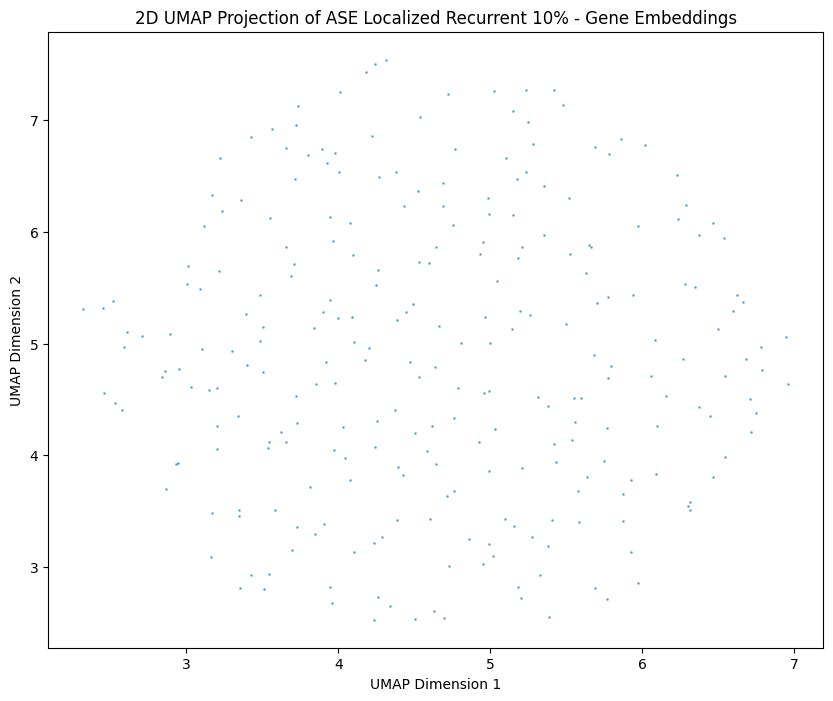

In [ ]:
import matplotlib.pyplot as plt

# Assuming embedding_2d is your 2D UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.5, s=1)
plt.title('2D UMAP Projection of ASE Localized Recurrent 10% - Gene Embeddings')

# Set the limits to zoom in; adjust these values based on the region you're interested in
# plt.xlim(-2, 2)  # Adjust these values
# plt.ylim(-2,2)  # Adjust these values

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
embedding_2d = reducer.fit_transform(gene_embeddings)

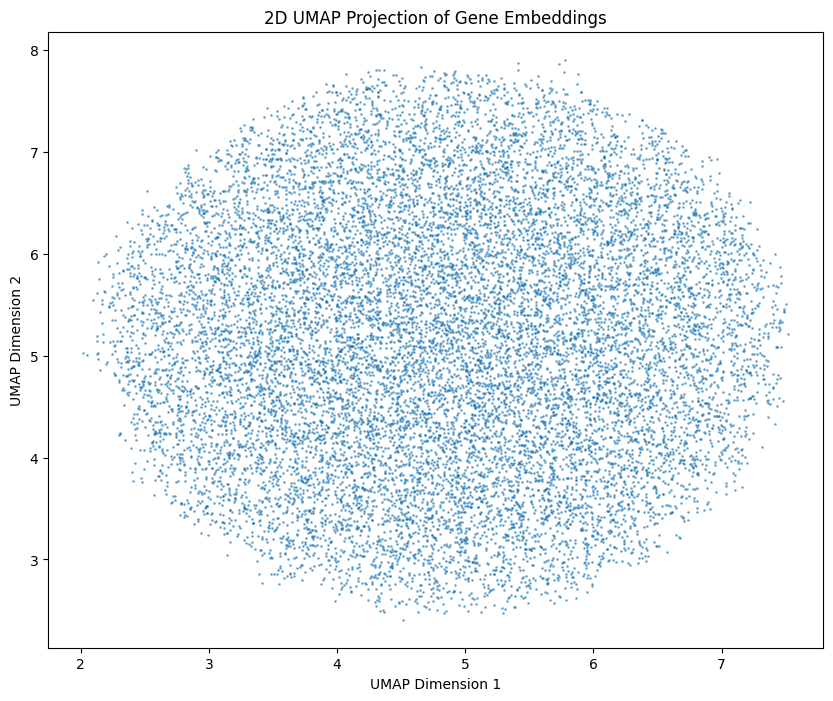

In [ ]:
import matplotlib.pyplot as plt

# Assuming embedding_2d is your 2D UMAP projection
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.5, s=1)
plt.title('2D UMAP Projection of Gene Embeddings')

# Set the limits to zoom in; adjust these values based on the region you're interested in
# plt.xlim(-2, 2)  # Adjust these values
# plt.ylim(-2,2)  # Adjust these values

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


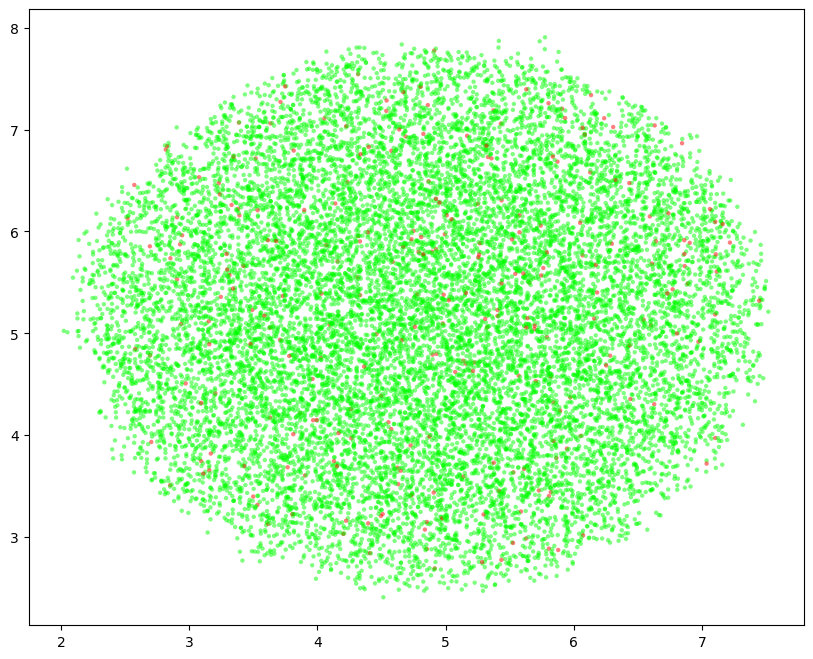

In [ ]:
import numpy as np

# Red array for highlights
red = np.zeros(embedding_2d.shape[0])
red[ase_localized_recurr10perc_indices] = 1

# Blue array for others
blue = np.ones(embedding_2d.shape[0])
blue[ase_localized_recurr10perc_indices] = 0

# Combine them
colors = np.stack([red, blue, np.zeros(len(red))], axis=1)

plt.figure(figsize=(10, 8))

plt.scatter(embedding_2d[:,0], embedding_2d[:,1],
           c=colors, edgecolor='none', alpha=0.5, s=10)



In [ ]:
from transformers import AutoTokenizer, RobertaModel

model = RobertaModel.from_pretrained("roberta-base")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_embeddings = model.embeddings.word_embeddings.weight.detach().cpu().numpy()

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
embedding_2d = reducer.fit_transform(roberta_embeddings)

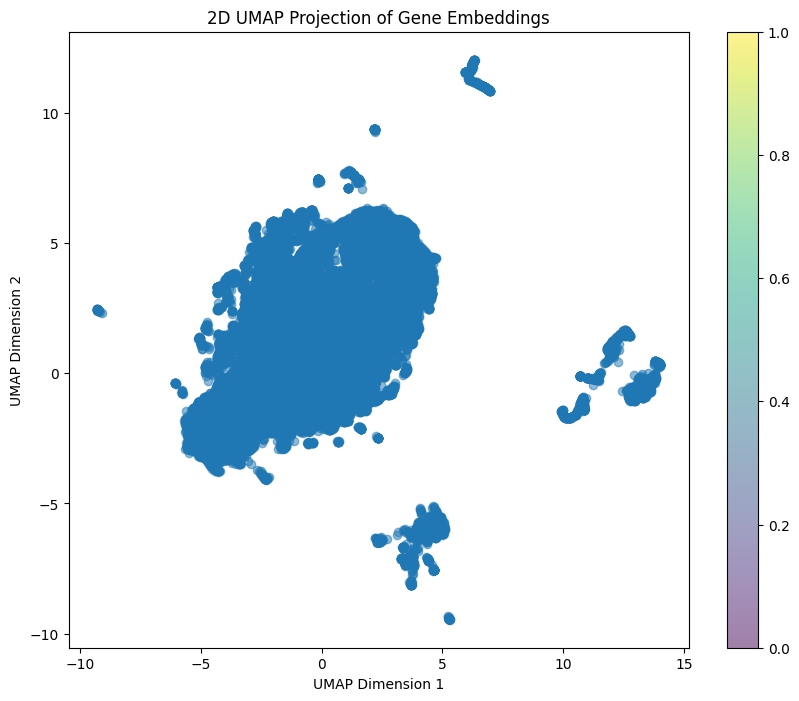

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.5)
plt.title('2D UMAP Projection of Gene Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar()
plt.show()